![TS banner](banner.png)

# A JWST NIRSpec/G395H transit as seen through `transitspectroscopy`
**Author**: Néstor Espinoza (Assistant Astronomer; Mission Scientist for Exoplanet Science)

**Last updated**: September 11, 2023

## Motivation & Data Description

In this notebook, we aim to obtain a JWST NIRSpec/G395H transit spectrum of [the exoplanet HAT-P-14~b (PID 1118; PI Proffitt)](https://www.stsci.edu/jwst/science-execution/program-information?id=1118) using `transitspectroscopy`. This dataset was obtained during JWST commissioning observations in order to study the spectrophotometric capabilities of the instrument. An initial analysis was shown in [Espinoza et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023PASP..135a8002E/abstract) --- here, we aim to reproduce a sort of "step by step" on how to reproduce (and improve upon!) those results.

As the documentation states, `transitspectroscopy` makes use of Stage 1 of the JWST Calibration Pipeline for most of its detector-level calibration. Because of this we list below the versions of the JWST pipeline and `transitspectroscopy` we will be using:

In [1]:
import jwst
import transitspectroscopy as ts

print('JWST Calibration pipeline version:', jwst.__version__)
print('transitspectroscopy version:', ts.__version__)

JWST Calibration pipeline version: 1.12.1
transitspectroscopy version: 0.4.0


And now let's load a set of helper libraries:

In [2]:
import glob

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('ticks')

<div class="alert alert-block alert-info"> <b>NOTE ON SCREAMING FACE EMOJIS (😱)</b>: In this notebook, we will use the very nice notation introduced on <a href="https://hastie.su.domains/ElemStatLearn/">"The Elements of Statistical Learning"</a> that consider screaming faces (😱) when starting some sections. Whenever you see one, it means the section can be skipped --- the content is interesting if you want a "deep dive" or "deeper knowledge" on the topic being discussed, but it is not needed to continue the tutorial.</div>

## 1. First steps: from raw data to ramps

### 1.1 Downloading the data
To start, let's download the corresponding JWST data. `transitspectroscopy` has a neat download function that uses `astroquery` to get you the data you need. The two things one needs to get this data is **the program ID (1118)** and the **observation number (5)**. Let's use that to download the data:

In [3]:
ts.jwst.download(pid = 1118, obs_num = '5')


	 >> 5.97 GB of data will be downloaded in total considering the following files:

 obsID   obs_collection dataproduct_type                 obs_id                ...    size    parent_obsid dataRights calib_level
-------- -------------- ---------------- ------------------------------------- ... ---------- ------------ ---------- -----------
83341594           JWST            image jw01118005001_02101_00001-seg001_nrs1 ...      72000     83341628     PUBLIC           1
83341589           JWST            image jw01118005001_02101_00002-seg001_nrs1 ...      60480     83341628     PUBLIC           1
83341591           JWST            image jw01118005001_04101_00001-seg001_nrs1 ... 1470738240     83341628     PUBLIC           1
83341595           JWST            image jw01118005001_04101_00001-seg001_nrs2 ... 1470738240     83341628     PUBLIC           1
83341592           JWST            image jw01118005001_04101_00001-seg002_nrs1 ... 1470738240     83341628     PUBLIC           1
833415

This will take a while --- but totally worth the beautiful JWST data! 

<div class="alert alert-block alert-info"> <b>Note:</b> By default, the function downloads the <code>uncal</code> data --- the uncalibrated data. This can be changed to download either ramps or rateints by using the flag <code>data_product</code> on the <code>ts.jwst.download</code> call (e.g., <code>ts.jwst.download(pid = 1118, obs_num = '5', data_product="rateints")</code> will download the rates per integration; <code>data_product="ramps"</code> downloads the calibrated ramps). </div>

In the output above, there's two things to note. First, there's "segments" of data, with filenames names including the words `seg001`, `seg002`, etc. Those are [data segments](https://jwst-docs.stsci.edu/getting-started-with-jwst-data/understanding-jwst-data-files/jwst-data-products): the ground mechanism for processing the data segments the entire TSO dataset into little pieces so it's easier to reduce, analyze and download the data. In addition, one can see there's two groups of `uncal` data that were downloaded --- the ones obtained in the `SUB32` subarray and the ones obtained in the `SUB2048` subarray. The latter are the ones that hold the transit, and they come in two detectors for the NIRSpec/G395H mode we are using here, NRS1 (3-4 microns) and NRS2 (4-5 microns); the former are [Target Acquisition images](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-target-acquisition/nirspec-wide-aperture-target-acquisition) that we will not analyze in this notebook.

### 1.2 Detector-level calibration

Now we have the data --- let's calibrate it! First, we perform detector-level calibration using `transitspectroscopy`. By default, the library performs the standard set of steps using STScI's [JWST Calibration Pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html) with some modifications depending on the instrument. For this NIRSpec/G395H data, the modification is in the jump-step: `transitspectroscopy` performs its own TSO-based jump detection algorithm by default.


To perform this, we first need to setup a list with the names of the files that we will be reducing. The download function above automatically downloads the data to a folder called `JWSTdata`. Note, as described above, there's data from two detectors --- let's extract filenames on lists for those:

In [4]:
nrs1_filenames = glob.glob('JWSTdata/jw01118005001_04101*nrs1_uncal.fits')
nrs2_filenames = glob.glob('JWSTdata/jw01118005001_04101*nrs2_uncal.fits')

Interesting to note: tools like `glob` don't necessarily sort the segments chronologically:

In [5]:
print(nrs1_filenames)

['JWSTdata/jw01118005001_04101_00001-seg003_nrs1_uncal.fits', 'JWSTdata/jw01118005001_04101_00001-seg002_nrs1_uncal.fits', 'JWSTdata/jw01118005001_04101_00001-seg001_nrs1_uncal.fits']


That's OK, the next function we will use, fixes this for us. 

#### 1.2.1 Loading data --- applying detector-calibration

The `transitspectroscopy` library for JWST data works by loading those datasets in an object; let's load it for NRS1 first:

In [6]:
nrs1_dataset = ts.jwst.load(nrs1_filenames, outputfolder = 'JWSTdata')

	    - Instrument/Mode: NIRSpec/G395H



This will load the three segments of data, and save any outputs in the `JWSTdata` folder (you can use any other folder, of course, to save your products!) under a new folder called `ts_outputs`. Note this sorts the filenames automatically:

In [7]:
nrs1_dataset.filenames

array(['JWSTdata/jw01118005001_04101_00001-seg001_nrs1_uncal.fits',
       'JWSTdata/jw01118005001_04101_00001-seg002_nrs1_uncal.fits',
       'JWSTdata/jw01118005001_04101_00001-seg003_nrs1_uncal.fits'],
      dtype='<U57')

All right! Let's perform some detector-level calibration:

In [8]:
nrs1_dataset.detector_calibration()

	 [START] Detector-level Calibration


	 >> Processing 3 files.

	    - TSO total duration: 6.0 hours
	    - Calibration parameters:
{'dq_init': {}, 'saturation': {}, 'refpix': {}, 'linearity': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'linearitystep'}, 'dark_sub': {}, 'jump': {'window': 10, 'nsigma': 10}, 'ramp_fit': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'ramp_fitstep'}, 'tracing': {'row_window': 1, 'column_window': 7}, 'superbias': {}, 'group_1f': {}, 'skip': {}}
	 >> Linearity files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 >> TSO-jump files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 [END] Detector-level Calibration




Let's explore what happened to this `nrs1_dataset` object --- first, note the data properties. The `nrs1_dataset` has a `ramps` array which holds the calibrated ramps:

In [9]:
nrs1_dataset.ramps.shape

(1139, 20, 32, 2048)

As can be seen, all segments add up to 1139 integrations, 20 groups each --- on a 32 x 2048 pixel subarray. If for some reason you wanted the ramps for each segment, you can inspect the `ramps_per_segment` **object**, which is actually a `jwst.RampModel` per segment:

In [10]:
len(nrs1_dataset.ramps_per_segment)

3

In [11]:
type(nrs1_dataset.ramps_per_segment[0])

stdatamodels.jwst.datamodels.ramp.RampModel

This is neat, because that one lets you access all the properties of a `RampModel` --- like the data itself, for instance:

In [12]:
nrs1_dataset.ramps_per_segment[0].data.shape

(561, 20, 32, 2048)

<div class="alert alert-block alert-info"> <b>Note:</b> The <code>data</code> in <code>nrs1_dataset.ramps_per_segment[0].data</code> is actually linked with the <code>nrs1_dataset.ramps</code> array for all steps of the pipeline if running them via <code>transitspectroscopy</code>. That is, changing a value in the <code>ramps_per_segment</code> will also change the corresponding <code>ramps</code> array. This is very powerful, as we will see in a moment!</div>

### 😱 1.3 TSO exploration via Correlated Double Sampling (CDS)

The products obtained above actually allow us to perform a quick exploration of the data using so-called Correlated Double Sampling (CDS) --- which is a fancy way of simply differencing subsequent groups with each other. That is, for a given integration, the correlated double samples are given by:

$CDS_i = G(t_i) - G(t_{i-1})$

It is called CDS because samples $CDS_i$ and $CDS_{i+1}$ are correlated. In theory, however, this correlation should be very small for high SNR regimes like TSOs. Further, given a constant rate, the CDS should be a constant. Let's find out if this is true! First, let's create the CDS samples by differencing on each integration:

In [12]:
# Create variable that will hold CDS samples:
nrs1_cds = np.zeros([nrs1_dataset.ramps.shape[0], 
                     nrs1_dataset.ramps.shape[1]-1, 
                     nrs1_dataset.ramps.shape[2], 
                     nrs1_dataset.ramps.shape[3]])

# Generate CDS samples:
for integration in range(nrs1_dataset.ramps.shape[0]):

    for group in range(nrs1_dataset.ramps.shape[1]-1):

        nrs1_cds[integration, group, :, :] = nrs1_dataset.ramps[integration, group + 1, :, :] - \
                                             nrs1_dataset.ramps[integration, group, :, :]

Let's take a quick look at the median CDS of the last group:

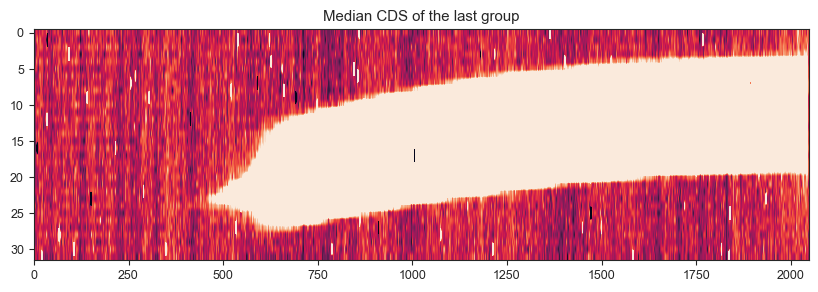

In [13]:
median_cds_last_group = np.nanmedian(nrs1_cds[:, -1, :, :], axis = 0)

plt.figure(figsize=(10,3))

im = plt.imshow(median_cds_last_group, aspect = 'auto',)
plt.title('Median CDS of the last group')
im.set_clim(-1,1)

Ah --- this looks gorgeous! There is some clear 1/f noise, however --- but other than that, the trace looks very nice. 

#### 1.3.1 Removing 1/f noise from CDS samples
Let's start by removing this 1/f noise throughout the CDS samples. A good trick to quickly do this is to identify a region of "only background pixels", and use the median and standard deviation on that region to detect background pixels in the frame as those that are below the median plus $n-\sigma$ away from them. Let's use the median CDS to do this: 

In [14]:
# Generate median CDS:
median_cds = np.nanmedian( nrs1_cds, axis = (0,1) )

# Flatten pixels for statistics only using pixels left-ward of column 500: 
pixel_counts = median_cds[:, :500].flatten()

m = np.nanmedian(pixel_counts)
sigma = ts.utils.get_mad_sigma(pixel_counts, m)

# Mask non-illuminated pixels:
idx = np.where(median_cds > m + 10*sigma)

# Illuminated pixels:
mask = np.ones(median_cds.shape)
mask[idx] = np.nan

Let's check how this mask looks like:

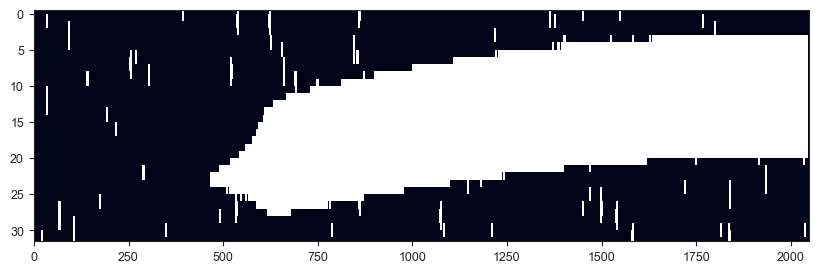

In [15]:
plt.figure(figsize=(10,3))

im = plt.imshow(mask, aspect = 'auto')

And the actual median CDS:

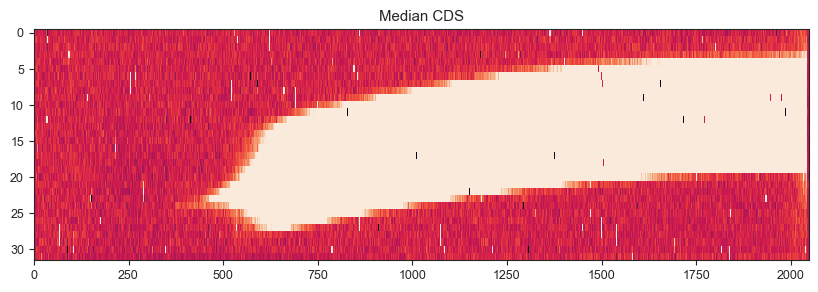

In [16]:
plt.figure(figsize=(10,3))

im = plt.imshow(median_cds, aspect = 'auto', interpolation = 'None')
plt.title('Median CDS')
im.set_clim(-1,1)

That looks great!

Let's then use this mask to correct for 1/f noise by simply masking pixels in the trace, and removing the mean of pixels just above and just below the trace for all CDS samples. Be careful to handle outliers as to not "kill" the column:

In [17]:
# First, get the indexes of all the non-iluminated rows of each column:
non_iluminated_rows = []
for column in range(nrs1_cds.shape[3]):

    non_iluminated_rows.append( np.where( ~np.isnan( mask[:, column] ) )[0] )

for integration in range(nrs1_cds.shape[0]):

    for group in range(nrs1_cds.shape[1]):

        for column in range(nrs1_cds.shape[3]):

            # First, get the non-iluminated rows that define the background of the current column:
            background_pixels = nrs1_cds[integration, group, non_iluminated_rows[column], column]

            # Estimate MAD sigma:
            median_background = np.nanmedian(background_pixels)
            sigma = ts.utils.get_mad_sigma(background_pixels, median_background)

            # Select pixel values within 5-sigma from the median:
            idx = np.where( np.abs(background_pixels - median_background) < 5*sigma )[0]
            
            # Now remove mean background from the CDS:
            nrs1_cds[integration, group, :, column] -= np.nanmean( background_pixels[idx] )

Let's see how we did both on an individual integration...

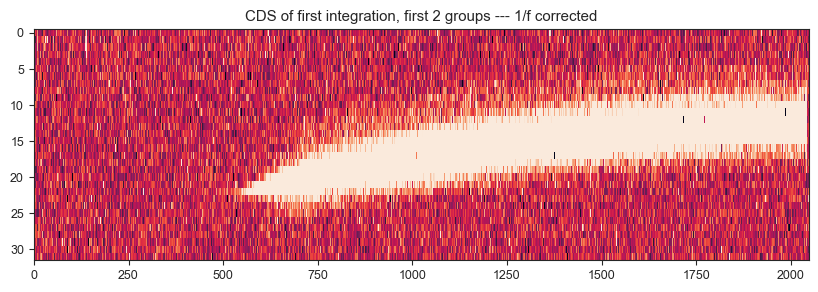

In [18]:
plt.figure(figsize=(10,3))

im = plt.imshow(nrs1_cds[10, 0, :, :], aspect = 'auto', interpolation = 'None')
plt.title('CDS of first integration, first 2 groups --- 1/f corrected')
im.set_clim(-30,30)

And on the median CDS of the first group:

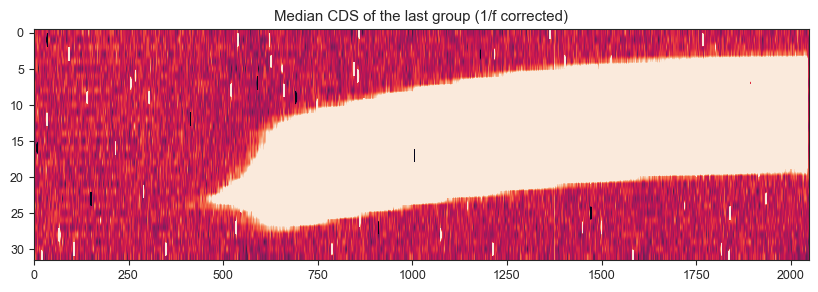

In [19]:
median_cds_last_group = np.nanmedian(nrs1_cds[:, -1, :, :], axis = 0)

plt.figure(figsize=(10,3))

im = plt.imshow(median_cds_last_group, aspect = 'auto',)
plt.title('Median CDS of the last group (1/f corrected)')
im.set_clim(-1,1)

That looks very pretty! Let's continue

#### 1.3.2 Correcting CDS ramps

So, back to our question above --- are the CDS's constant accross integrations? Let's plot this for a given pixel --- say (15, 1500):

Text(0, 0.5, 'CDS (counts)')

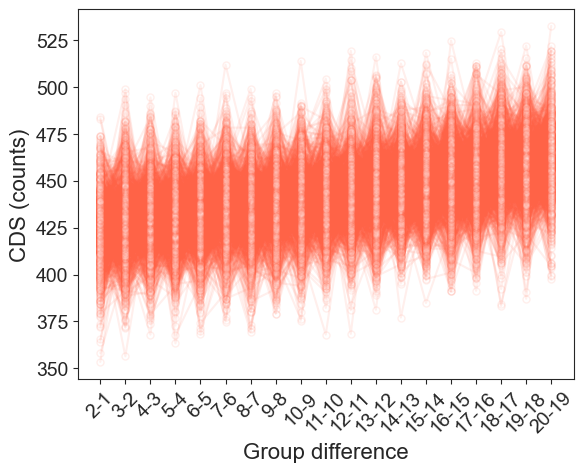

In [20]:
# First, generate X-axis:
group_difference = []
for group in range(nrs1_dataset.ramps.shape[1]-1):

    group_difference.append(str(group+2)+'-'+str(group+1))

# Now plot all the CDS on top of each other:
for integration in range(nrs1_dataset.ramps.shape[0]):

        plt.plot( nrs1_cds[integration, :, 15, 1500], '-o', 
                                                     mfc = 'white', 
                                                     mec = 'tomato', 
                                                     color = 'tomato',
                                                     alpha = 0.1)

plt.xticks(range(nrs1_dataset.ramps.shape[1]-1), group_difference, fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

plt.xlabel('Group difference', fontsize = 16)
plt.ylabel('CDS (counts)', fontsize = 16)

Ah --- _very_ interesting! Note the CDS on all groups are _not_ constant --- which implies some effect is going (e.g., imperfect non-linearity correction, charge migration, etc.). Let's try to fix this.

First, let's see how repeatable this trend is accross groups. First, note how it seems the very first few CDS's are more or less constant, with the rise happening at group differences around 5. Let's divide the median CDS count on the first five CDSs:

Text(0, 0.5, 'Relative flux')

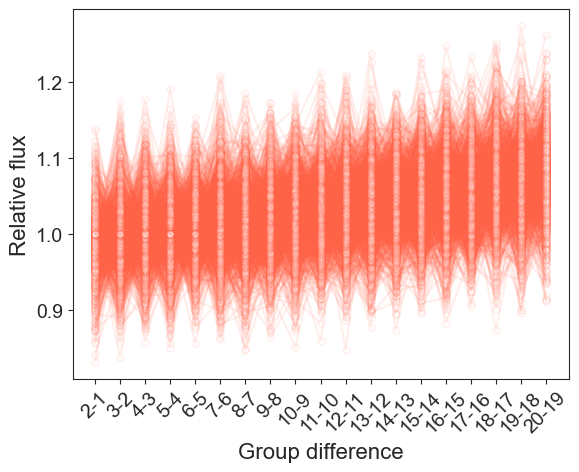

In [21]:
# First, generate X-axis:
group_difference = []
for group in range(nrs1_dataset.ramps.shape[1]-1):

    group_difference.append(str(group+2)+'-'+str(group+1))

# Now plot all the CDS on top of each other:
for integration in range(nrs1_dataset.ramps.shape[0]):

        plt.plot( nrs1_cds[integration, :, 15, 1500] / np.nanmedian( nrs1_cds[integration, :, 15, 1500][:5] ), '-o', 
                                                     mfc = 'white', 
                                                     mec = 'tomato', 
                                                     color = 'tomato',
                                                     alpha = 0.1)

plt.xticks(range(nrs1_dataset.ramps.shape[1]-1), group_difference, fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

plt.xlabel('Group difference', fontsize = 16)
plt.ylabel('Relative flux', fontsize = 16)

Remarkably stable accross integrations. Note also that the change of this rate is quite significant --- about 5%! Let's correct this by calculating the median relative flux at each CDS:

Text(0, 0.5, 'Relative flux')

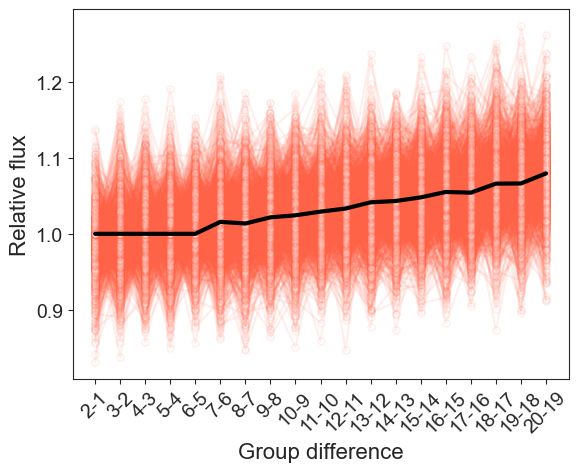

In [22]:
all_cds = np.zeros([nrs1_cds.shape[0], nrs1_cds.shape[1]])

for integration in range(nrs1_dataset.ramps.shape[0]):

    all_cds[integration, :] = nrs1_cds[integration, :, 15, 1500] / np.nanmedian( nrs1_cds[integration, :, 15, 1500][:5])

median_offset = np.nanmedian(all_cds, axis = 0)

# Now plot all the CDS on top of each other:
for integration in range(nrs1_dataset.ramps.shape[0]):

        plt.plot( nrs1_cds[integration, :, 15, 1500] / np.nanmedian( nrs1_cds[integration, :, 15, 1500][:5] ), '-o', 
                                                     mfc = 'white', 
                                                     mec = 'tomato', 
                                                     color = 'tomato',
                                                     alpha = 0.1)

plt.plot( median_offset, lw = 3, color = 'black' )

plt.xticks(range(nrs1_dataset.ramps.shape[1]-1), group_difference, fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

plt.xlabel('Group difference', fontsize = 16)
plt.ylabel('Relative flux', fontsize = 16)

Let's use this to correct the original CDS of this pixel:

Text(0, 0.5, 'Corrected CDS (counts)')

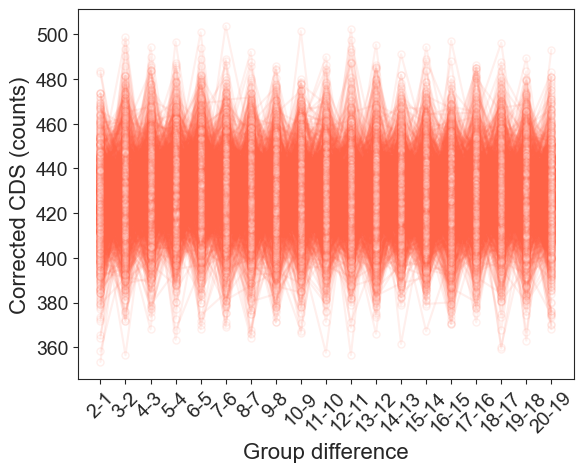

In [23]:
# First, generate X-axis:
group_difference = []
for group in range(nrs1_dataset.ramps.shape[1]-1):

    group_difference.append(str(group+2)+'-'+str(group+1))

# Now plot all the CDS on top of each other:
for integration in range(nrs1_dataset.ramps.shape[0]):

        plt.plot( nrs1_cds[integration, :, 15, 1500] / median_offset, '-o', 
                                                     mfc = 'white', 
                                                     mec = 'tomato', 
                                                     color = 'tomato',
                                                     alpha = 0.1)

plt.xticks(range(nrs1_dataset.ramps.shape[1]-1), group_difference, fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

plt.xlabel('Group difference', fontsize = 16)
plt.ylabel('Corrected CDS (counts)', fontsize = 16)

Nice! Let's repeat this for every pixel out there; let's write a function that does this:

In [24]:
from copy import deepcopy

def correct_cds(cds, ngroups):
    """
    This function takes `cds` samples of dimensions `(integrations, groups, pixel, pixel)` and, for each pixel, 
    uses the first `ngroups` to normalize each individual integration, find the median trend in the CDS per group 
    difference and correct this.

    Input
    -----

    cds : np.array
        CDS samples of dimensions `(integrations, groups, pixel, pixel)` that want to be corrected.
    ngroup : int
        Number of groups to use for normalization

    Output
    ------
    
    corrected_cds : np.array
    """

    corrected_cds = deepcopy(cds)

    all_cds = np.zeros([corrected_cds.shape[0], corrected_cds.shape[1]])
    for row in range(corrected_cds.shape[2]):

        for column in range(corrected_cds.shape[3]):

            for integration in range(corrected_cds.shape[0]):
    
                all_cds[integration, :] = corrected_cds[integration, :, row, column] / \
                                          np.nanmedian( corrected_cds[integration, :, row, column][:ngroups])
    
            median_offset = np.nanmedian(all_cds, axis = 0)
            corrected_cds[:, :, row, column] = corrected_cds[:, :, row, column] / median_offset

    return corrected_cds

In [25]:
nrs1_corrected_cds = correct_cds(nrs1_cds, 5)

Let's check:

Text(0, 0.5, 'Relative flux')

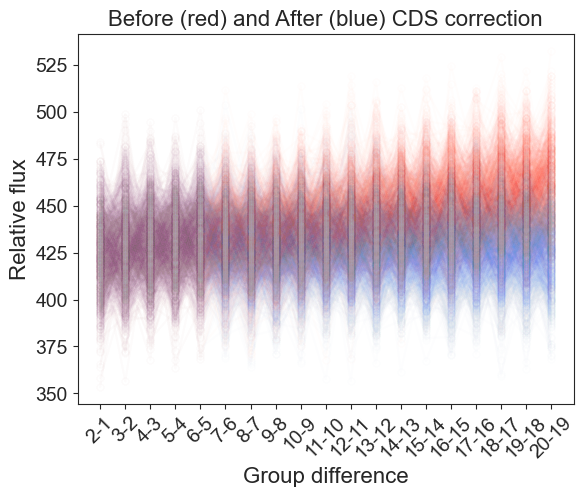

In [26]:
# First, generate X-axis:
group_difference = []
for group in range(nrs1_dataset.ramps.shape[1]-1):

    group_difference.append(str(group+2)+'-'+str(group+1))

# Now plot all the CDS on top of each other:
plt.title('Before (red) and After (blue) CDS correction', fontsize = 16)
for integration in range(nrs1_dataset.ramps.shape[0]):

        plt.plot( nrs1_cds[integration, :, 15, 1500] , '-o', 
                                                     mfc = 'white', 
                                                     mec = 'tomato', 
                                                     color = 'tomato',
                                                     alpha = 0.01)

        plt.plot( nrs1_corrected_cds[integration, :, 15, 1500] , '-o', 
                                                     mfc = 'white', 
                                                     mec = 'cornflowerblue', 
                                                     color = 'cornflowerblue',
                                                     alpha = 0.01)

plt.xticks(range(nrs1_dataset.ramps.shape[1]-1), group_difference, fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

plt.xlabel('Group difference', fontsize = 16)
plt.ylabel('Relative flux', fontsize = 16)

Nice! Let's move to extracting a white-light lightcurve.

#### 1.3.4 CDS Spectral Tracing & Extraction

Let's now extract a white-light lightcurve from these CDS. First, let's perform a simple tracing of the _median_ CDS. We already calculated that one above, but that one was calculated without 1/f correction; let's do it again so we get a (slightly) "better" one:

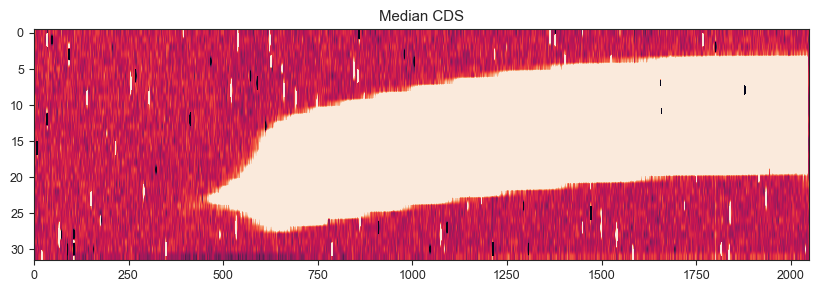

In [27]:
median_cds = np.nanmedian(nrs1_corrected_cds, axis = (0,1))

plt.figure(figsize=(10,3))

im = plt.imshow(median_cds, aspect = 'auto')
plt.title('Median CDS')
im.set_clim(-1,1)

Let's trace it using `transitspectroscopy`. To this we need a starting point --- let's start from pixel column 2042. What row do we use as a starting point? Let's check:

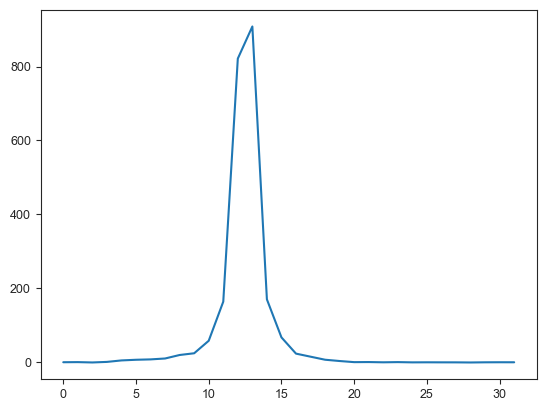

In [28]:
plt.plot(median_cds[:, 2042])

It seems row number 13 would do by eye. Let's do just that:

In [29]:
x1, y1 = ts.spectroscopy.trace_spectrum(median_cds, np.zeros(median_cds.shape), 
                                        xstart = 2042, ystart = 13, xend = 700, 
                                        y_tolerance = 5, 
                                        method = 'convolve', 
                                        ccf_function = 'gaussian',
                                        ccf_parameters = [0., 1.7]
                                        )   

Let's see how we did:

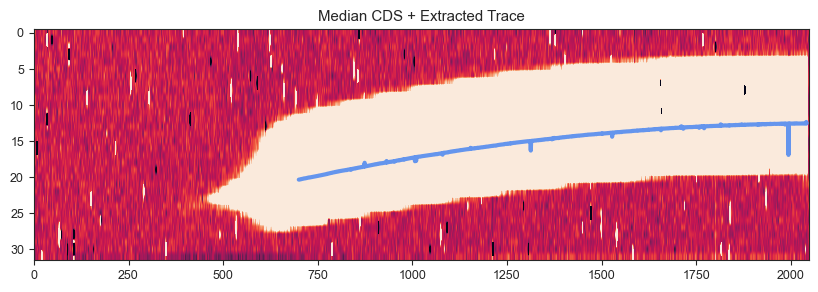

In [30]:
plt.figure(figsize=(10,3))

im = plt.imshow(median_cds, aspect = 'auto')

plt.plot(x1, y1, color = 'cornflowerblue', lw = 3)

plt.title('Median CDS + Extracted Trace')
im.set_clim(-1,1)

That looks great --- let's handle some outliers and smooth it:

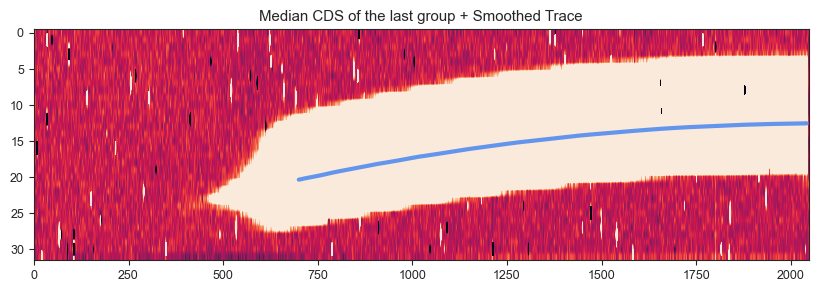

In [31]:
from scipy.ndimage import median_filter

# Do a median filter that will help get the general trend of the data; get MAD-sigma:
mf = median_filter(y1, 3)
residuals = mf - y1
sigma = ts.utils.get_mad_sigma(residuals, np.nanmedian(residuals))

# Identify values above 5-sigma from that, replace them by the median filter:
idx = np.where( np.abs(mf - y1) > 5*sigma )[0]
new_y1 = np.copy(y1)
new_y1[idx] = mf[idx] 

# Smooth trace:
_, ysmooth = ts.utils.fit_spline(x1, new_y1, nknots = 60)

plt.figure(figsize=(10,3))

im = plt.imshow(median_cds, aspect = 'auto')

plt.plot(x1, ysmooth, color = 'cornflowerblue', lw = 3)

plt.title('Median CDS of the last group + Smoothed Trace')
im.set_clim(-1,1)

Fantastic! Before going to spectral extraction, let's find and correct outliers in the time-series. To this end, we generate the time-series for every pixel on each individual CDS sample (to avoid correlations). Then, we find outliers, and replace them with the best estimate of the value in that time-series. 

To exemplify what we'll do, we do it in a single pixel and a single set of CDS samples. Let's take the first CDS samples, and play with pixel (15,1700):

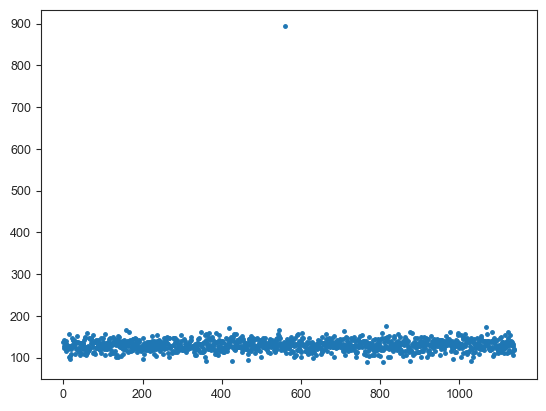

In [32]:
plt.plot(nrs1_corrected_cds[:, 0, 15, 1700], '.')

Let's catch the outlier using median filters:

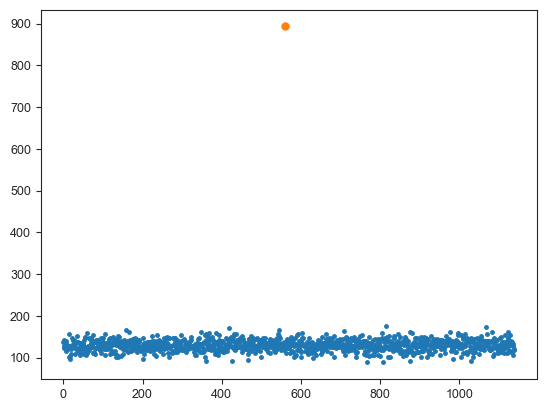

In [33]:
# Do a median filter of the time-series:
mf = median_filter(nrs1_corrected_cds[:, 0, 15, 1700], 11)
residuals = mf - nrs1_corrected_cds[:, 0, 15, 1700]
sigma = ts.utils.get_mad_sigma(residuals, np.nanmedian(residuals))

# Identify values above 5-sigma from the time-series --- identify those as outliers:
idx = np.where( np.abs(mf - nrs1_corrected_cds[:, 0, 15, 1700]) > 5*sigma )[0]

# Plot them:
plt.plot(nrs1_corrected_cds[:, 0, 15, 1700], '.')
plt.plot(idx, nrs1_corrected_cds[:, 0, 15, 1700][idx], 'o')

Nice! Let's repeat this for every pixel, every CDS sample. As with the traces, we replace the value by the median filter value:

In [34]:
for row in range(nrs1_corrected_cds.shape[2]):

    for column in range(nrs1_corrected_cds.shape[3]):

        for sample in range(nrs1_corrected_cds.shape[1]):

            # Do a median filter of the time-series:
            mf = median_filter(nrs1_corrected_cds[:, sample, row, column], 11)
            residuals = mf - nrs1_corrected_cds[:, sample, row, column]
            sigma = ts.utils.get_mad_sigma(residuals, np.nanmedian(residuals))
            
            # Identify values above 5-sigma from the time-series --- identify those as outliers:
            idx = np.where( np.abs(mf - nrs1_corrected_cds[:, sample, row, column]) > 5*sigma )[0]

            # Replace by median filter value:
            nrs1_corrected_cds[idx, sample, row, column] = mf[idx]

Let's see if the obvious outlier above got corrected:

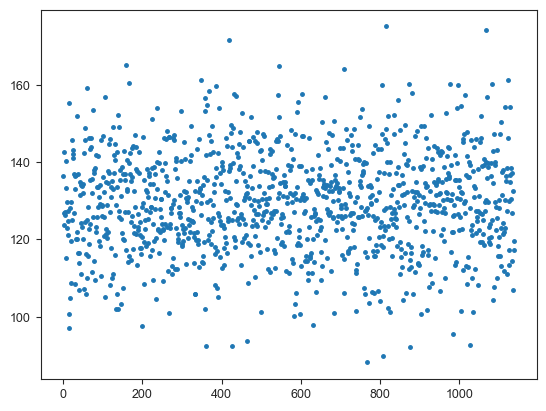

In [35]:
plt.plot(nrs1_corrected_cds[:, 0, 15, 1700], '.')

It was! Now, let's perform spectral extraction on each of these corrected CDS frames:

In [36]:
nrs1_cds_spectra = np.zeros([nrs1_corrected_cds.shape[0], nrs1_corrected_cds.shape[1], len(x1)])

for integration in range(nrs1_corrected_cds.shape[0]):

    for sample in range(nrs1_corrected_cds.shape[1]):

        nrs1_cds_spectra[integration, sample, :] = ts.spectroscopy.getSimpleSpectrum(nrs1_corrected_cds[integration, sample, :, :], 
                                                                                     x1, 
                                                                                     ysmooth,
                                                                                     5, 
                                                                                     correct_bkg = False)

Let's plot all the CDS spectra for one integration:

(0.0, 1343.0)

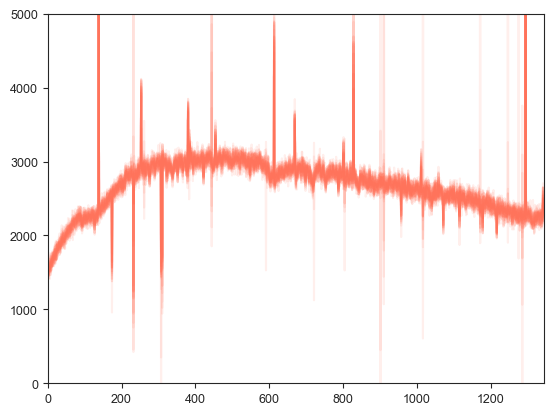

In [42]:
integration = 10

for group in range(nrs1_cds_spectra.shape[1]):
    
    plt.plot( nrs1_cds_spectra[integration, group, :], color = 'tomato', alpha = 0.1 )

plt.ylim(0,5000)
plt.xlim(0, nrs1_cds_spectra.shape[2])

Nice! What about comparing accross integrations?

(0.0, 1343.0)

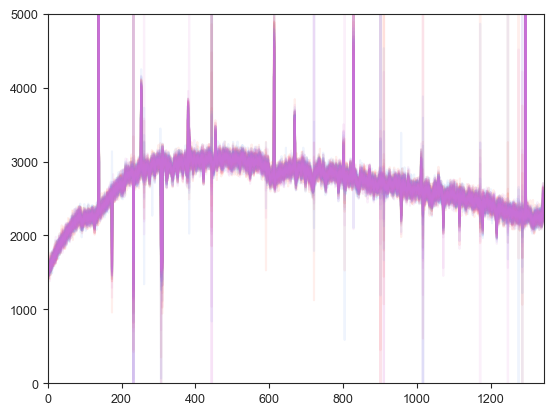

In [43]:
integration = 10

for group in range(nrs1_cds_spectra.shape[1]):
    
    plt.plot( nrs1_cds_spectra[integration, group, :], color = 'tomato', alpha = 0.1 )

integration = 100

for group in range(nrs1_cds_spectra.shape[1]):
    
    plt.plot( nrs1_cds_spectra[integration, group, :], color = 'cornflowerblue', alpha = 0.1 )

integration = 1000

for group in range(nrs1_cds_spectra.shape[1]):
    
    plt.plot( nrs1_cds_spectra[integration, group, :], color = 'orchid', alpha = 0.1 )


plt.ylim(0,5000)
plt.xlim(0, nrs1_cds_spectra.shape[2])

This looks great; some outliers here and there, but this works accross integrations! Let's try figuring out a white-light lightcurve and the impact of outliers next.


#### 1.3.4 CDS White-light lightcurve

Let's go ahead and compute a white-light lightcurve out of all the CDS:

In [44]:
nrs1_cds_spectra.shape

(1139, 19, 1343)

In [49]:
white_light_cds = np.zeros([nrs1_cds_spectra.shape[0] * nrs1_cds_spectra.shape[1]])

counter = 0
for integration in range(nrs1_cds_spectra.shape[0]):

    for group in range(nrs1_cds_spectra.shape[1]):

        white_light_cds[counter] = np.nansum( nrs1_cds_spectra[integration, group, :] )
        counter += 1

Let's see how it looks like:

(0.0, 21641.0)

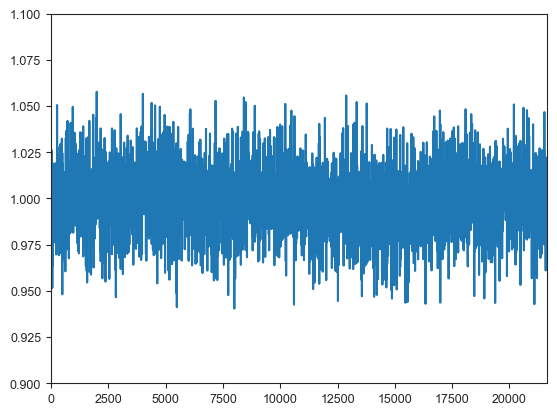

In [52]:
plt.plot(white_light_cds / np.nanmedian(white_light_cds))
plt.ylim(0.9,1.1)
plt.xlim(0, len(white_light_cds))

That looks quite noisy. Could this be outliers messing our spectra? To understand if this is the case, let's correct them. First, let's put all the spectra of all CDS in a single 2D array:

In [53]:
nrs1_cds_spectra2D = np.zeros([nrs1_cds_spectra.shape[0] * nrs1_cds_spectra.shape[1], nrs1_cds_spectra.shape[2]])

counter = 0
for integration in range(nrs1_cds_spectra.shape[0]):

    for group in range(nrs1_cds_spectra.shape[1]):

        nrs1_cds_spectra2D[counter, :] =  nrs1_cds_spectra[integration, group, :]
        counter += 1

Let's compare the median spectra to the spectra above we plotted of all:

(0.0, 1343.0)

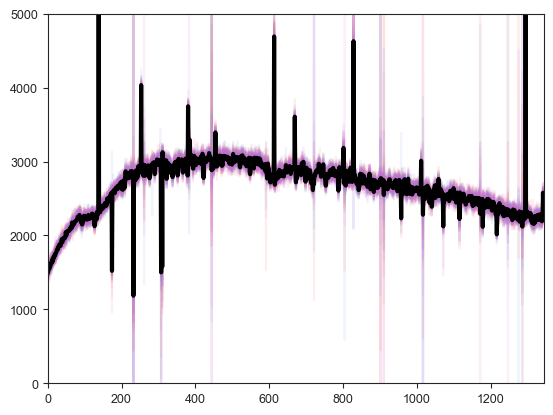

In [54]:
integration = 10

for group in range(nrs1_cds_spectra.shape[1]):
    
    plt.plot( nrs1_cds_spectra[integration, group, :], color = 'tomato', alpha = 0.1 )

integration = 100

for group in range(nrs1_cds_spectra.shape[1]):
    
    plt.plot( nrs1_cds_spectra[integration, group, :], color = 'cornflowerblue', alpha = 0.1 )

integration = 1000

for group in range(nrs1_cds_spectra.shape[1]):
    
    plt.plot( nrs1_cds_spectra[integration, group, :], color = 'orchid', alpha = 0.1 )

plt.plot( np.nanmedian( nrs1_cds_spectra2D, axis = 0 ), color = 'black', lw = 3 )

plt.ylim(0,5000)
plt.xlim(0, nrs1_cds_spectra.shape[2])

All right, let's use the difference at each column/wavelength to detect outliers:

In [ ]:
median_spectra = np.nanmedian( nrs1_cds_spectra2D, axis = 0 )

# Compute the ratio of each spectra to the median, which we'll use to scale the spectra:
ratios = nrs1_cds_spectra2D / median_spectra

Indeed --- up-the-ramp samples happening! 

#### 1.2.2 Fitting the ramps

Let's now perform ramp-fitting. This uses the ramp-fitting step from the JWST pipeline directly, and applies it to our data:

In [10]:
nrs1_dataset.fit_ramps()

	 >> Rampfit files found for jw01118005001_04101_00001-seg001_nrs1. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg002_nrs1. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg003_nrs1. Loading them...



Perfect! Let's repeat steps for NRS2:

In [142]:
nrs2_dataset = ts.jwst.load(nrs2_filenames, outputfolder = 'JWSTdata')
nrs2_dataset.detector_calibration()
nrs2_dataset.fit_ramps()

	    - Instrument/Mode: NIRSpec/G395H

	 [START] Detector-level Calibration


	 >> Processing 3 files.

	    - TSO total duration: 6.0 hours
	    - Calibration parameters:
{'dq_init': {}, 'saturation': {}, 'refpix': {}, 'linearity': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'linearitystep'}, 'dark_sub': {}, 'jump': {'window': 10, 'nsigma': 10}, 'ramp_fit': {'output_dir': 'JWSTdata/ts_outputs', 'save_results': True, 'suffix': 'ramp_fitstep'}, 'superbias': {}, 'group_1f': {}, 'skip': {}}
	 >> Linearity files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 >> TSO-jump files found. Loading them...

	    - Instrument/Mode: NIRSpec/G395H

	 [END] Detector-level Calibration


	 >> Rampfit files found for jw01118005001_04101_00001-seg001_nrs2. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg002_nrs2. Loading them...

	 >> Rampfit files found for jw01118005001_04101_00001-seg003_nrs2. Loading them...



All right! The `rateints` are stored in the same object for one to explore. As expected, we have...

In [143]:
print(len(nrs1_dataset.rateints), 'products per segment for NRS1, and',len(nrs1_dataset.rateints),'for NRS2')

3 products per segment for NRS1, and 3 for NRS2


#### Neat!

### 😱 1.4 Exploring detector-calibration results: `nan` pixels in ramps

Before, we have performed ramp-fitting: that is, fitted the ramps with lines to obtain the so-called "rates per integration". This gives, thus, one "rate" image per integration. Let's study how these look like.

Let's first look at the 100th integration of the 2nd segment of data to see how the rates are looking like:

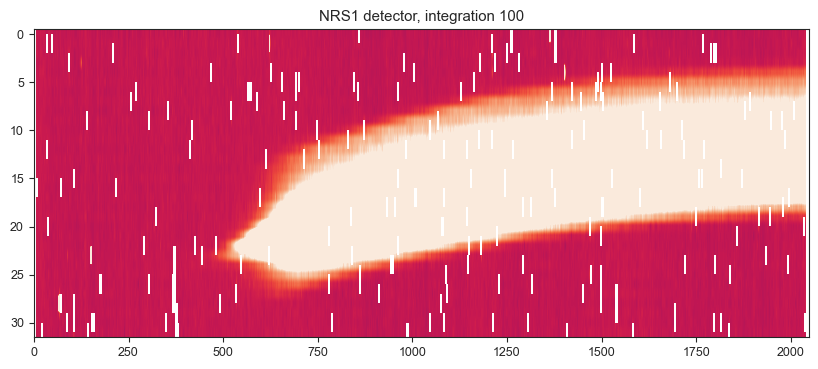

In [168]:
plt.figure(figsize=(10,4))
plt.title('NRS1 detector, integration 100')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
im.set_clim(-10,10)

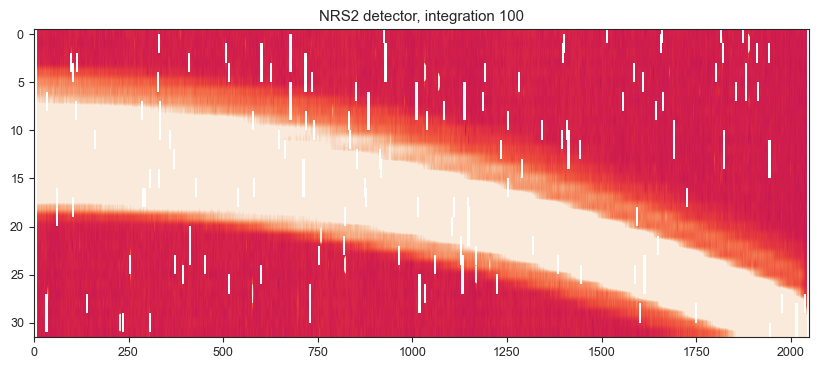

In [169]:
plt.figure(figsize=(10,4))
plt.title('NRS2 detector, integration 100')
im = plt.imshow(nrs2_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
im.set_clim(-10,10)

Rates are looking good, although plots like this are interesting because we do see some pixels marked as white. As it turns out, those are `nan` values! How many are there on each detector on integration 100?

In [144]:
print('Number of nan in NRS1, integration 100, segment 2:', len(np.where(np.isnan(nrs1_dataset.rateints[1].data[100, :, :]))[0]))
print('Number of nan in NRS2, integration 100, segment 2:', len(np.where(np.isnan(nrs2_dataset.rateints[1].data[100, :, :]))[0]))

Number of nan in NRS1, integration 100, segment 2: 547
Number of nan in NRS2, integration 100, segment 2: 601


On the order of ~600 on both detectors, which is about 0.91% of the pixels. This is a little bit under twice the number of [non-operable pixels](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-performance) which might rise an initial question about their origin. Let's explore this!

#### 1.3.1 Exploring non-operable pixels through pixel data-quality (`pixeldq`)

Our first suspect on those `nan` pixels is the pipeline. Could it be the processing itself the one that is giving rise to those `nan` values? To explore this, let's first note `transitspectroscopy` gives us a hint in terms of the pipeline and *context* around which these results were obtained:

In [22]:
for params in ['Ramp-fitting STScI Pipeline Version', 'Ramp-fitting CRDS context']:

    print(params, nrs1_dataset.calibration_parameters[params])

Ramp-fitting STScI Pipeline Version 1.11.3
Ramp-fitting CRDS context jwst_1123.pmap


This is important in case we find something interesting and [we want to report it](https://jwst-docs.stsci.edu/jwst-help-desk). 

First, let us get familiar with the fact that white pixels above are `nan`; let's print the values for NRS1, column 752, which seems to have one of those white pixels:

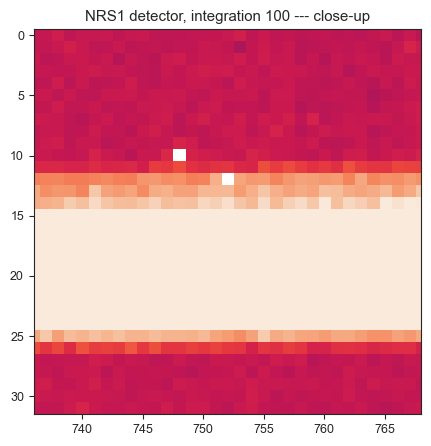

In [170]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(752-16,752+16)
im.set_clim(-10,10)

In [30]:
nrs1_dataset.rateints[1].data[100, :, 752]

array([-9.8871924e-02, -3.3673489e-01, -2.1998818e-01,  1.6637030e-01,
       -7.5028551e-01, -2.2644097e-01, -5.2583468e-01, -2.9469073e-01,
        8.4030166e-02, -2.1537757e-01, -8.4375434e-02,  1.5087349e+00,
                  nan,  7.4087372e+00,  9.3609076e+00,  1.2132249e+01,
        2.1443344e+01,  3.4084160e+01,  1.1266605e+02,  5.7615472e+02,
        1.1768058e+03,  2.3638702e+02,  5.6952450e+01,  2.9846521e+01,
        1.3485019e+01,  5.9979992e+00,  1.6897780e+00, -8.4474772e-02,
       -2.4862169e-01, -5.6544967e-02, -3.0937231e-01, -6.3854182e-01],
      dtype='>f4')

Hmmm. Interesting. It seems this is at row number 12:

In [32]:
nrs1_dataset.rateints[1].data[100, 12, 752]

nan

Bingo! Let's check first other integrations. Do they all have `nan`s?

In [33]:
nrs1_dataset.rateints[1].data[:, 12, 752]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

Holy Oleo, Batman! That's a lot of `nan`. Let's explore the ramp of integration 100 --- is it particularly bad, perhaps? (Calibrated) ramps are stored in `nrs1_dataset.ramps` --- let's get the one for this pixel. To compare, let's plot the ones to the left and right of it, too:

In [151]:
nrs1_dataset.ramps[1].data.shape

(561, 20, 32, 2048)

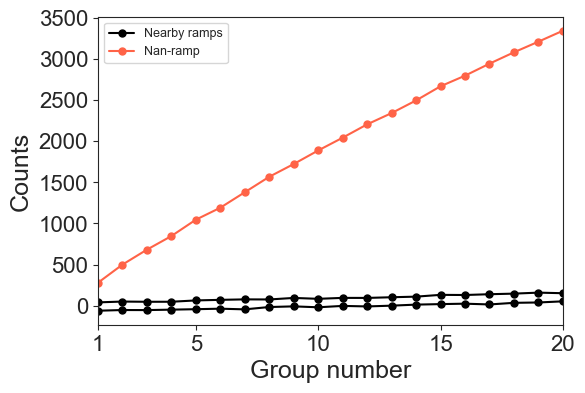

In [177]:
plt.figure(figsize=(6,4))

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 751], 'o-', color = 'black', label = 'Nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 753], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 752], 'o-', color = 'tomato', label = 'Nan-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)

plt.legend()

Ah. Indeed, the pixel does seem special. It has much higher counts than pixels around it. There's an array, the `pixeldq` array, which showcases the pixel `d`ata `q`uality --- so  What does the data-quality says about this pixel?

In [40]:
nrs1_dataset.ramps[1].pixeldq[12, 752]

2049

That number doesn't tell us match. Luckily, there's a function to translate that number to words:

In [41]:
from jwst.datamodels import dqflags

dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[12, 752], mnemonic_map = dqflags.pixel)

{'DO_NOT_USE', 'HOT'}

Ah. A hot pixel! That actually makes a lot of sense. It's set to `DO_NOT_USE` because of this --- and this sets the ramp in the ramp-fitting stage to a `nan`. 

But --- are _all_ those `nan` we see in NRS1 hot pixels? Let's count the `DO_NOT_USE` pixels and check if all have something attached:

In [59]:
x_nan, y_nan = np.where(np.isnan(nrs1_dataset.rateints[1].data[100, :, :]))

all_flags = []

pixeldq_do_not_use = 0
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        pixeldq_do_not_use += 1
    
        if len(flags) > 1:
    
            for flag in flags:
    
                if flag != 'DO_NOT_USE':
    
                    all_flags.append(flag)

        else:

            all_flags.append('No details')

In total, there are:

In [60]:
print(pixeldq_do_not_use, 'pixels marked as DO_NOT_USE in the pixeldq.')

251 pixels marked as DO_NOT_USE in the pixeldq.


Yes, those are not _all_ the `nan` pixels (above, we found 547 were `nan`). We'll solve the mistery of the remaining 296 pixels below; for now, let's keep looking at these. First, let's see the histogram of what causes a `DO_NOT_USE` pixel:

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

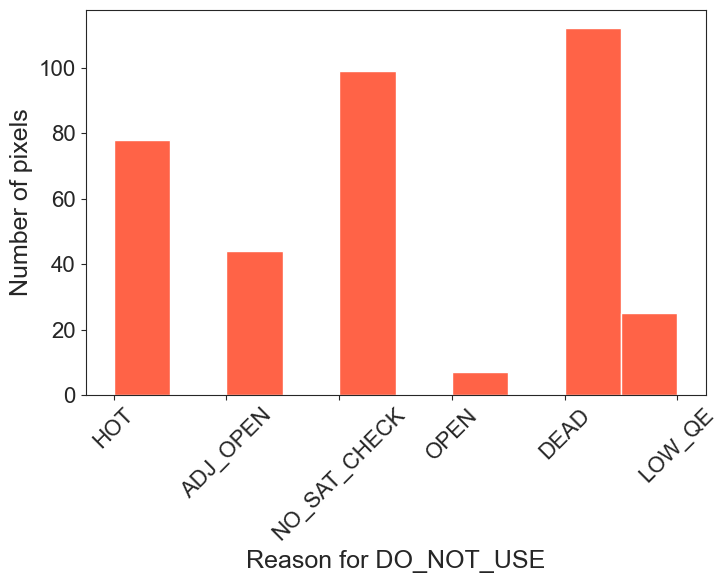

In [187]:
plt.figure(figsize=(8,5))

plt.hist(all_flags, histtype='barstacked', color = 'tomato')
plt.xlabel('Reason for DO_NOT_USE', fontsize = 18)
plt.ylabel('Number of pixels', fontsize = 18)

plt.xticks(fontsize = 16, rotation = 45)

plt.yticks(fontsize = 16)

An explainer of what most each of those reasons mean [can be found in the JWST Documentation](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-performance). Briefly, `DEAD` pixels are the worst because they don't really respond to light. `OPEN` pixels are pixels that have low response, and light leaks into `ADJ_OPEN` pixels; so probably not great for science either. `LOW_QE` have low response to light --- so might be OK in principle for TSOs (just lower SNR). 

`NO_SAT_CHECK` [are pixels that are just not checked for saturation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/description.html). This is because these pixels have no thresholds on their saturation levels (e.g., something went wrong when calculating those and they don't have values) --- and are set as `DO_NOT_USE`. For NIRSpec, pixels that have any of the other flags are not checked for saturation, and thus they end up having `NO_SAT_CHECK`. This highlights an important caveat of the distribution above: pixels might have more than one reason to be flagged as `DO_NOT_USE`.

Let' have a look at a few example of each, for illustration purposes. We already catched a `HOT` pixel. Let's now catch the `OPEN` pixel ramps: 

In [69]:
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'OPEN' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan[i], y_nan[i])

Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 0 1261
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 1 1377
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 24 371
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 26 370
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 27 369
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 27 371
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'OPEN'} (X,Y) pixel coords: 30 376


Note all of those are to the left of the spectrum, or above it. So not impacting the signal --- so we won't bother with those in NRS1. What about NRS2?

In [72]:
x_nan2, y_nan2 = np.where(np.isnan(nrs2_dataset.rateints[1].data[100, :, :]))

for i in range( len(x_nan2) ):

    flags = dqflags.dqflags_to_mnemonics(nrs2_dataset.ramps[1].pixeldq[x_nan2[i], y_nan2[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'OPEN' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan2[i], y_nan2[i])

None of those. Neat! Let's jump to `DEAD` pixels:

In [73]:
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'DEAD' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan[i], y_nan[i])

Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 0 1377
Flags: {'DO_NOT_USE', 'DEAD'} (X,Y) pixel coords: 1 35
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 47
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 1210
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 1211
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 1 1767
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 2 208
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 2 1789
Flags: {'HOT', 'DO_NOT_USE', 'DEAD'} (X,Y) pixel coords: 2 1801
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 978
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 1178
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 1179
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 3 1281
Flags: {'DO_NOT_USE', 'NO_SAT_CHECK', 'DEAD'} (X,Y) pixel coords: 4 467
Flags: {'D

Let's check pixel (12, 1716). The `rateints` looks like this:

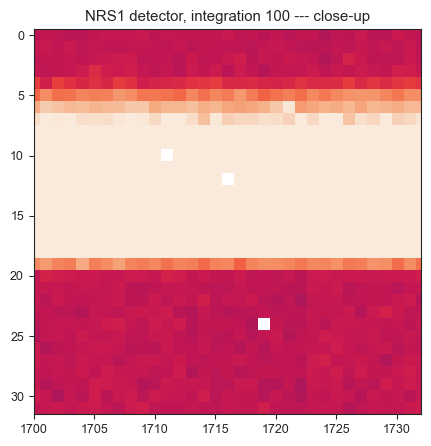

In [190]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(1716-16,1716+16)
im.set_clim(-10,10)

And the ramp:

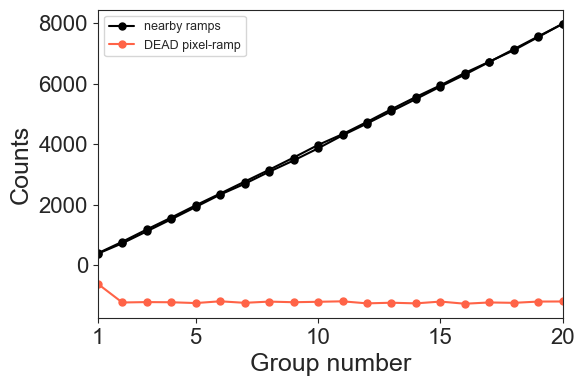

In [188]:
plt.figure(figsize=(6,4))

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 1717], 'o-', color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 1715], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 12, 1716], 'o-', color = 'tomato', label = 'DEAD pixel-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Yep, that's pretty dead. What about `LOW_QE` pixels?

In [77]:
for i in range( len(x_nan) ):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if 'DO_NOT_USE' in flags:

        if 'LOW_QE' in flags:
            
            print('Flags:', flags, '(X,Y) pixel coords:', x_nan[i], y_nan[i])

Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 1 538
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 3 92
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 5 845
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 5 1681
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 7 255
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 7 590
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 7 1892
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 8 521
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 9 140
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 9 691
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 9 1066
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 10 748
Flags: {'LOW_QE', 'DO_NOT_USE'} (X,Y) pixel coords: 12 413
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 15 1758
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 17 596
Flags: {'HOT', 'DO_NOT_USE', 'LOW_QE'} (X,Y) pixel coords: 17 1005


Let's check pixel (5, 845):

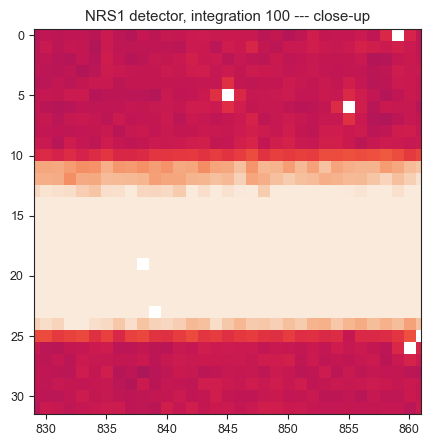

In [189]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(845-16,845+16)
im.set_clim(-10,10)

Turns out _some_ signal is leaking, just like `OPEN` pixels. Let's see ramps:

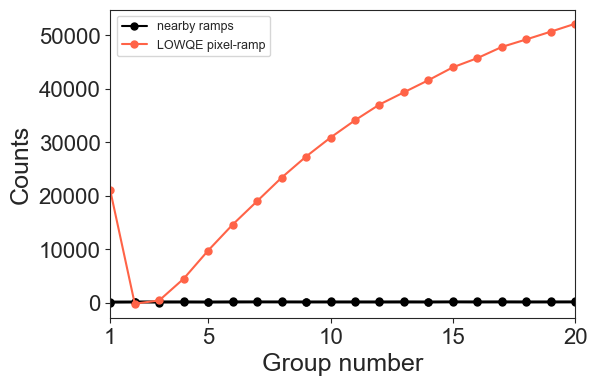

In [191]:
plt.figure(figsize=(6,4))


plt.plot( nrs1_dataset.ramps[1].data[100,:, 5, 845-1], 'o-', color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 5, 845+1], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 5, 845], 'o-', color = 'tomato', label = 'LOWQE pixel-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Well, turns out _that_ pixel is going a bit crazy. So, again, rightfully masked out.

#### 1.3.2 What's with the rest of the pixels? 

So --- from all the `nan` pixels, let's find out the ones that don't have a "rightfully masked out" pixel:

In [124]:
x_nan, y_nan = np.where(np.isnan(nrs1_dataset.rateints[1].data[100, :, :]))

In [134]:
nan_no_dnu = 0
for i in range(len(x_nan)):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if (not 'DO_NOT_USE' in flags):

        print(nan_no_dnu,':',x_nan[i], y_nan[i], ' --- is nan, but not pixeldq flagged:',flags)
        nan_no_dnu += 1

0 : 0 0  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
1 : 0 1  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
2 : 0 2  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
3 : 0 3  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
4 : 0 2043  --- is nan, but not pixeldq flagged: set()
5 : 0 2044  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
6 : 0 2045  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
7 : 0 2046  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
8 : 0 2047  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
9 : 1 0  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
10 : 1 1  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
11 : 1 2  --- is nan, but not pixeldq flagged: {'NO_SAT_CHECK', 'REFERENCE_PIXEL'}
12 : 1 3  --- is nan, but not

Ah! Most of them are reference pixels. If we take those out, what are we left with?

In [136]:
nan_no_dnu = 0
for i in range(len(x_nan)):

    flags = dqflags.dqflags_to_mnemonics(nrs1_dataset.ramps[1].pixeldq[x_nan[i], y_nan[i]], mnemonic_map = dqflags.pixel)

    if (not 'DO_NOT_USE' in flags) and (not 'REFERENCE_PIXEL' in flags):
        
        print(nan_no_dnu,':',x_nan[i], y_nan[i], ' --- is nan, but not pixeldq flagged:',flags)
        nan_no_dnu += 1

0 : 0 2043  --- is nan, but not pixeldq flagged: set()
1 : 1 2043  --- is nan, but not pixeldq flagged: set()
2 : 2 2043  --- is nan, but not pixeldq flagged: set()
3 : 3 2043  --- is nan, but not pixeldq flagged: set()
4 : 4 2043  --- is nan, but not pixeldq flagged: set()
5 : 5 2043  --- is nan, but not pixeldq flagged: set()
6 : 6 2043  --- is nan, but not pixeldq flagged: set()
7 : 7 2043  --- is nan, but not pixeldq flagged: set()
8 : 8 2043  --- is nan, but not pixeldq flagged: set()
9 : 9 2043  --- is nan, but not pixeldq flagged: set()
10 : 10 2043  --- is nan, but not pixeldq flagged: set()
11 : 11 2043  --- is nan, but not pixeldq flagged: set()
12 : 12 2043  --- is nan, but not pixeldq flagged: set()
13 : 13 2043  --- is nan, but not pixeldq flagged: set()
14 : 14 2043  --- is nan, but not pixeldq flagged: set()
15 : 15 2043  --- is nan, but not pixeldq flagged: set()
16 : 16 2043  --- is nan, but not pixeldq flagged: set()
17 : 17 2043  --- is nan, but not pixeldq flagged: 

Interesting --- 40 `nan` pixels without an explanation, all together on columns 2043 and 1538, 1539 and 1540. Let's see first what's up with pixel 2043. These are pixels that are right next to reference pixels (located in columns 2044, 2045, 2046 and 2047):

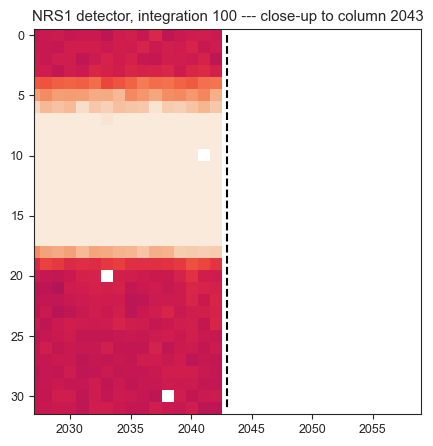

In [193]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up to column 2043')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.plot([2043, 2043], [0,31], 'k--')
plt.xlim(2043-16,2043+16)
im.set_clim(-10,10)

Indeed, entire column is a `nan`! Let's see how the ramps look like for one of those pixels. Say, row 15:

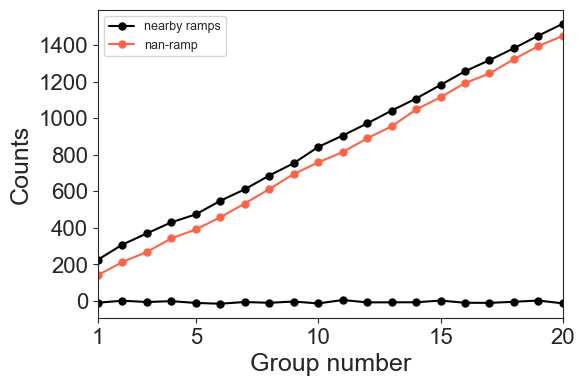

In [194]:
plt.figure(figsize=(6,4))


plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043-1], 'o-', color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043+1], 'o-', color = 'black')

plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043], 'o-', color = 'tomato', label = 'nan-ramp' )

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Interesting! There is nothing _particularly_ wrong with this ramp. One nearby ramp has zero flux because is a reference pixel (and thus doesn't respond to light). The other is a bit higher in counts, but very similar slope. So -- are _all_ the ramps `nan` for this column, or perhaps this is just the case for this integration?

In [196]:
nrs1_dataset.rateints[1].data[:, 15, 2043]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

They are _all_ `nan`! Hmmm. Let's plot _all_ the ramps on top of each other --- perhaps the ramp behaves weirdly and the jump detection is detecting and flagging this weirdness?

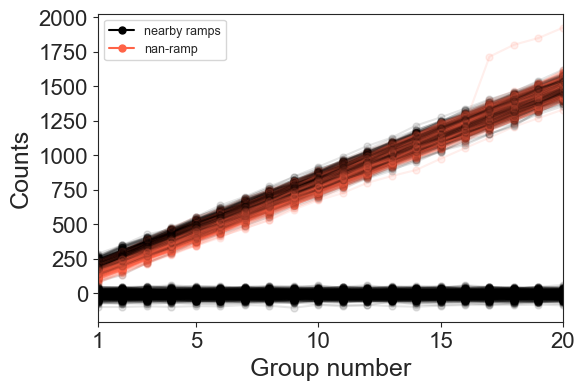

In [202]:
plt.figure(figsize=(6,4))

for i in range(nrs1_dataset.rateints[1].data.shape[0]):

    if i == 0:
        
        plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043-1], 'o-', color = 'black', label = 'nearby ramps')
        plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043+1], 'o-', color = 'black')
        
        plt.plot( nrs1_dataset.ramps[1].data[100,:, 15, 2043], 'o-', color = 'tomato', label = 'nan-ramp' )

    else:

        plt.plot( nrs1_dataset.ramps[1].data[i,:, 15, 2043-1], 'o-', color = 'black', alpha = 0.1)
        plt.plot( nrs1_dataset.ramps[1].data[i,:, 15, 2043+1], 'o-', color = 'black', alpha = 0.1)
        
        plt.plot( nrs1_dataset.ramps[1].data[i,:, 15, 2043], 'o-', color = 'tomato',alpha = 0.1)

plt.xlabel('Group number', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)

plt.xticks([0, 4, 9, 14, 19], 
           ['1', '5', '10', '15', '20'],
           fontsize = 16)

plt.yticks(fontsize = 16)


plt.xlim(0, 19)
plt.legend()

Huh. Nothing _particularly_ special about the ramp, other than a few outliers. So --- why is it `nan`? Well, there's another data-quality set of flags we haven't checked: the `groupdq`. Those are group-dependant data quality flags that are set up, typically by the `jump` step of the pipeline. Let's check it out for this ramp: 



In [205]:
nrs1_dataset.ramps[1].groupdq[100, :, 15, 2043]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

Huh. Nothing either! This is very strange. Time to report this perhaps.

Let's check now the other set of pixels, around coluns 1538, 1539 and 1540:

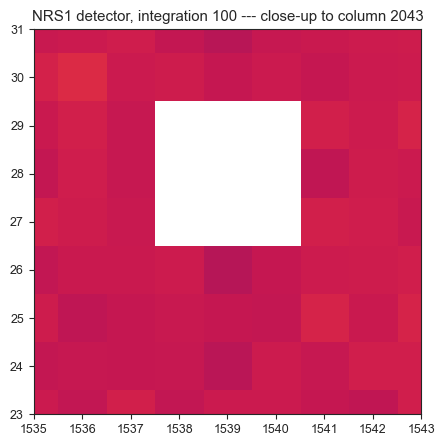

In [213]:
plt.figure(figsize=(5,5))
plt.title('NRS1 detector, integration 100 --- close-up to column 2043')
im = plt.imshow(nrs1_dataset.rateints[1].data[100, :, :], aspect = 'auto',)
plt.xlim(1539-4,1539+4)
plt.ylim(27-4,27+4)
im.set_clim(-10,10)

Interesting! A clear square of pixels. Let's grab one of them and figure out what is going on --- let's say pixel (28, 1538), and the two pixels to the left of it:

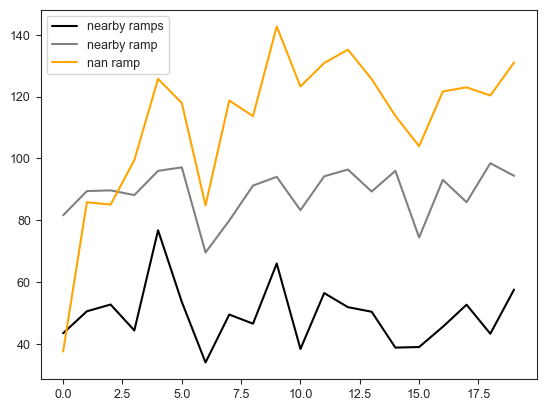

In [215]:
plt.plot( nrs1_dataset.ramps[1].data[100,:, 28, 1538-1], color = 'black', label = 'nearby ramps')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 28, 1538-2], color = 'grey', label = 'nearby ramp')
plt.plot( nrs1_dataset.ramps[1].data[100,:, 28, 1538], color = 'orange', label = 'nan ramp' )

plt.legend()

Hmm. Nothing particularly weird with the ramp. Why is it `nan`? Pixel data-quality is...

In [207]:
nrs1_dataset.ramps[1].pixeldq[28, 1538]

0

...good; what about group data-quality:

In [209]:
nrs1_dataset.ramps[1].groupdq[100,:, 28, 1538]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=uint8)

Aha! This is marking it as 2, which is:

In [219]:
dqflags.dqflags_to_mnemonics(2, mnemonic_map = dqflags.pixel)

{'SATURATED'}

Saturated!? That is very weird. Is it the same for all pixels in the square?

In [221]:
for i in [27, 28, 29]:

    for j in [1538, 1539, 1540]:

        print(nrs1_dataset.ramps[1].groupdq[100,:, i, j])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [222]:
dqflags.dqflags_to_mnemonics(3, mnemonic_map = dqflags.pixel)

{'DO_NOT_USE', 'SATURATED'}

Yes, except for one that is marked as both, saturated _and_ `DO_NOT_USE`. Time to report, too!